In [215]:
%matplotlib inline
from scipy import linalg
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Image
from math import (log,ceil,floor)
from scipy.fft import fft, ifft
from scipy.linalg import dft, inv, expm, norm
from numpy.linalg import matrix_power
from qiskit.quantum_info.analysis import hellinger_fidelity,hellinger_distance
from qiskit import( ClassicalRegister,
        QuantumRegister,
        QuantumCircuit,
        execute,
        Aer,
        IBMQ,
        transpile)
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy
from qiskit.providers.aer.noise import NoiseModel
from qiskit.visualization import( plot_histogram,
                        plot_state_city,
                        plot_gate_map, 
                        plot_circuit_layout)
from qiskit.circuit.library import QFT
style = {'figwidth':10,'fontsize':17,'subfontsize':14}
styleWide = {'figwidth':25,'fontsize':17,'subfontsize':14}

plt.rcParams['figure.figsize'] = 11,8
matplotlib.rcParams.update({'font.size' : 15})

import warnings
warnings.filterwarnings("ignore")

In [65]:
def simul(qc,stateVec,shots):
    if stateVec:
        backend = Aer.get_backend('statevector_simulator')
        result = execute(qc,backend,shots=shots).result().get_statevector(qc,decimals=3)
    else:
        backend = Aer.get_backend('qasm_simulator')
        result = execute(qc,backend,shots=shots).result().get_counts()
    return result

def normalizedResultDict(baseDict,qiskitDict):
    "Returns the result of merging qiskit produced dictionaries with dictionaries produced from multBinResultDict for graph formatting reasons."
    new_d1 = baseDict
    new_d2= qiskitDict
    normalizedResultDict = {**new_d1,**new_d2}
    return normalizedResultDict

def decResultDict(n):
    "Retuns a dictionary composed of a range of N keys converted to binary."
    baseDict = {}
    for decNumber in range(2**n):
        dec = decNumber 
        baseDict[dec] = 0
    return baseDict

def resultsSim(N,circ,shots,Decimal):
    "Returns the dictionary produced by QASM simulator with the MSB changed to convention, and values (previously frequencies) converted to probabilities."
    result = simul(circ,False,shots)
    baseDict = decResultDict(N)
    if Decimal:
        correctedResultAux = { int(k[::-1],2) : v/shots for k, v in result.items()}
    else:
        correctedResultAux = { k : v/shots for k, v in result.items()}
    correctedResult = normalizedResultDict(baseDict,correctedResultAux)
    return correctedResult


In [208]:
def circulant_adjacency(n,v): #--- it computes an adjacency matrix for the circulant graph
    iv = list(range(0,n))
    av = list(range(0,n-1))
    C = np.zeros([n,n])
    for z in range(n):
        C[z,0] = v[iv[z]]
    for x in range(1,n):
        av = iv[0:-1]
        iv[0] = iv[-1]
        iv[1::] = av
        for y in range(0,n):
            C[y,x] = v[iv[y]]
    return C

def unitary_ctqw(gamma, N, A, marked, t): #---
    Oracle = np.zeros([N,N])
    for x in marked:
        Oracle[x,x] = 1
    U = expm(1j*(-gamma*A - Oracle)*t)
    return U

def trotter(gamma, N, A, marked, t, n_trotter):
    O = np.zeros([N,N])
    for x in marked:
        O[x,x] = 1
    U = matrix_power(expm(1j*(-gamma*A)*t/n_trotter)@expm(1j*(- O)*t/n_trotter), n_trotter)
    return U

def diagUniOp(N,diagU0):
    qreg = QuantumRegister(N)
    creg = ClassicalRegister(N)
    circ = QuantumCircuit(qreg,name='    UniOp    ')
    circ.diagonal(diagU0,qreg) 
    return circ

def initialCond(qc,string,N):
    for x in range(N):
        if string[x] == '1':
            qc.x(x)
    return qc

def contCirc(N,diagUniOp,t,initString):
    qreg = QuantumRegister(N,'q')
    creg = ClassicalRegister(N,'c')
    circ = QuantumCircuit(qreg,creg)
    if t == 0: 
        circ = initialCond(circ,initString,N)
        circ.measure(qreg,creg)
        return circ 
    else:
        circ = initialCond(circ,initString,N)
        circ.barrier()
        circ.append(QFT(N,do_swaps=False,approximation_degree=0,inverse=True,name='    QFT    '),range(N))
        circ.barrier()
        circ.append(diagUniOp,range(N))
        circ.barrier()
        circ.append(QFT(N,do_swaps=False,approximation_degree=0,inverse=False,name='    IQFT    '),range(N))
        circ.barrier()
        circ.measure(qreg,creg)
    return circ

def drawDiagUni(N,diagU0,style):
    qreg = QuantumRegister(N,'q')
    creg = ClassicalRegister(N,'c')
    circ = QuantumCircuit(qreg,name='    UniOp    ')
    circ.diagonal(diagU0,qreg) 
    circ = transpile(circ,basis_gates=['cp','h','cx','rz'])
    return circ

In [202]:
N = 8 
NCirc = 3
gamma =  1/(2*np.sqrt(2))
t = 1
time = [1]
c = [0,1] + [0 for x in range(N-3)] + [1]
initString = '100'
qft = dft(N, scale = 'sqrtn')
iqft = inv(qft)
adj = circulant_adjacency(N,c)
A = iqft@circulant_adjacency(N,c)@qft
diagA = np.diag(A)
U0 = unitary_ctqw(gamma, N, A, [],t)
diagU0 = np.diag(U0).tolist()
U = iqft@U0@qft

shots = 3000
UCirc = diagUniOp(NCirc,diagU0)
continuousCirc = contCirc(NCirc,UCirc,t,initString)

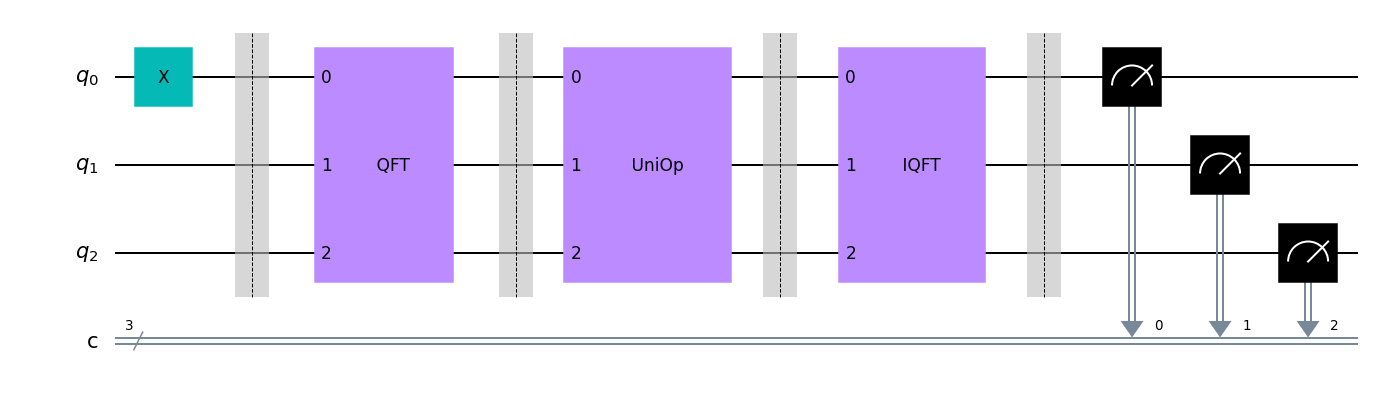

<Figure size 1800x513.003 with 0 Axes>

In [218]:
display(continuousCirc.draw(output='mpl',fold=-1,style=styleWide))
plt.clf()

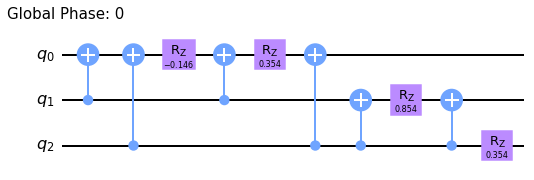

<Figure size 688.597x204.68 with 0 Axes>

In [219]:
circ = drawDiagUni(NCirc,diagU0,styleWide)
display(circ.draw(output='mpl',fold=-1))
plt.clf()

{0: 0, 1: 0, 2: 0.003, 3: 0.117, 4: 0.7683333333333333, 5: 0.109, 6: 0.0023333333333333335, 7: 0.0003333333333333333}


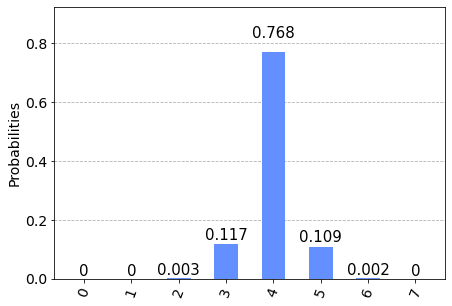

<Figure size 504x360 with 0 Axes>

In [72]:
results = resultsSim(NCirc,continuousCirc,3000,True)
print(results)
display(plot_histogram(results))
plt.clf()

## QASM Results

### Mult result functions

In [213]:
def multDiagUniOp(N,NCirc,gamma,adjacency,timeList):
    unitaryCircList = []
    for t in timeList:
        U0 = unitary_ctqw(gamma,N,adjacency,[],t)
        diagU0 = np.diag(U0).tolist()
        diagCirc = diagUniOp(NCirc,diagU0)
        unitaryCircList.append(diagCirc)
    return unitaryCircList

def multContCirc(N,diagUniOpList,timeList,initString):
    circList = []
    for steps,diagUniOp in zip(timeList,diagUniOpList):
        circ =  contCirc(N,diagUniOp,t,initString)
        circList.append(circ)
    return circList

def multResultsSim(multipleCircs,shots):
    resultList = []
    result = {}
    correctedResult = {}
    for circ in multipleCircs:
        result = simul(circ,False,shots)
        correctedResult = { int(k[::-1],2) : v/shots for k, v in result.items()}
        resultList.append(correctedResult)
        result = {}
    return resultList

def multDecResultDict(N,steps):
    "Returns multiple binary dictionaries."
    baseResultDictList = []
    for step in steps:
        baseDict = decResultDict(N)
        baseResultDictList.append(baseDict)
    return baseResultDictList

def multNormalizedResultDict(baseDictList,qiskitDictList):
    normalizedResultDictList = []
    for baseDict,qiskitDict in zip(baseDictList,qiskitDictList):
        baseDict.update(qiskitDict)
        normalizedResultDictList.append(baseDict)
    return normalizedResultDictList
    
def multSubPlotIbmSim(resultListSim,resultListIbm,steps,backend):
    Tot = len(steps)
    Cols = 1
    # Compute Rows required
    Rows = Tot // Cols
    Rows += Tot % Cols
    # Create a Position index
    Position = range(1,Tot + 1)
    fig = plt.figure(1)
    i = 0
    for k,resultDictSim,resultDictIbm,step in zip(range(Tot),resultListSim,resultListIbm,steps):
            countsSim = resultDictSim.values()
            countsIbm = resultDictIbm.values()
            ax = fig.add_subplot(Rows,Cols,Position[k])
            if i ==0:
                ax.set_title("Time=%s"%step)
                ax.bar(*zip(*enumerate(countsSim)),width=-0.4,bottom=0,align='edge',label='qasm_simulator')
                ax.bar(*zip(*enumerate(countsIbm)),width= 0.4,bottom=0,align='edge',label=str(backend))
                ax.legend()
            else:
                ax.set_title("Time=%s"%step)
                ax.bar(*zip(*enumerate(countsSim)),width=-0.4,bottom=0,align='edge')
                ax.bar(*zip(*enumerate(countsIbm)),width=0.4,bottom=0,align='edge')
            plt.ylim(0,1.2)
            plt.yticks([0,0.5,1])
            plt.xlim(0-1,len(countsSim))
            w = ax.get_xaxis()
            if(i==Tot-1):
                w.set_visible(True)
                plt.xticks(range(0,len(countsSim)))
            else:
                w.set_visible(False)
            i+=1
    plt.xlabel("Graph Node")
    plt.ylabel("Probability")
    fig.tight_layout(pad=1.0)
    
def multSubPlotSim(resultListSim,steps):
    Tot = len(steps)
    Cols = 1
    # Compute Rows required
    Rows = Tot // Cols
    Rows += Tot % Cols
    # Create a Position index
    Position = range(1,Tot + 1)
    fig = plt.figure(1)
    i = 0
    for k,resultDictSim,step in zip(range(Tot),resultListSim,steps):
            countsSim = resultDictSim.values()
            ax = fig.add_subplot(Rows,Cols,Position[k])
            if i ==0:
                ax.set_title("Time=%s"%step)
                ax.bar(*zip(*enumerate(countsSim)),width=-0.4,bottom=0,align='edge',label='qasm_simulator')
                ax.legend()
            else:
                ax.set_title("Time=%s"%step)
                ax.bar(*zip(*enumerate(countsSim)),width=-0.4,bottom=0,align='edge')
            plt.ylim(0,1.2)
            plt.yticks([0,0.5,1])
            plt.xlim(0-1,len(countsSim))
            w = ax.get_xaxis()
            if(i==Tot-1):
                w.set_visible(True)
                plt.xticks(range(0,len(countsSim)))
            else:
                w.set_visible(False)
            i+=1
    plt.xlabel("Graph Node")
    plt.ylabel("Probability")
    fig.tight_layout(pad=1.0)

def plotMultipleQiskit(N,multipleCircs,steps,shots):
    qiskitSimResultList = multResultsSim(multipleCircs,shots)
    baseDictList = multDecResultDict(N,steps)
    normalizedResultDictList = multNormalizedResultDict(baseDictList,qiskitSimResultList)
    fig = multSubPlotSim(normalizedResultDictList,steps)
    return fig

def plotMultipleQiskitIbmSim(N,multResultSim,ibmJobDictList,steps,shots,Decimal,backend):
    "Brings every dictionar and plot building functions together to either show or save the matplotlib figure."
    formatedSimList = multResultSim
    decResultIBM = multDecResultDict(N,steps)
    decResultSIM = multDecResultDict(N,steps)
    normalizedResultListIbm = multNormalizedResultDict(decResultIBM,ibmJobDictList)
    normalizedResultListSim = multNormalizedResultDict(decResultSIM,formatedSimList)
    print("normalizedResultListIbm %s"%normalizedResultListIbm)
    print()
    print("normalizedResultListSim %s"%normalizedResultListSim)
    fig = multSubPlotIbmSim(normalizedResultListIbm,normalizedResultListSim,steps,backend)
    return fig

[{4: 1.0}, {4: 0.7686666666666667, 3: 0.11133333333333334, 5: 0.114, 2: 0.0033333333333333335, 6: 0.0023333333333333335, 7: 0.0003333333333333333}, {3: 0.31633333333333336, 4: 0.30633333333333335, 2: 0.041, 5: 0.2816666666666667, 7: 0.0026666666666666666, 6: 0.048, 1: 0.0036666666666666666, 0: 0.0003333333333333333}, {5: 0.324, 2: 0.144, 6: 0.13833333333333334, 3: 0.31666666666666665, 1: 0.021666666666666667, 4: 0.025333333333333333, 7: 0.021333333333333333, 0: 0.008666666666666666}]


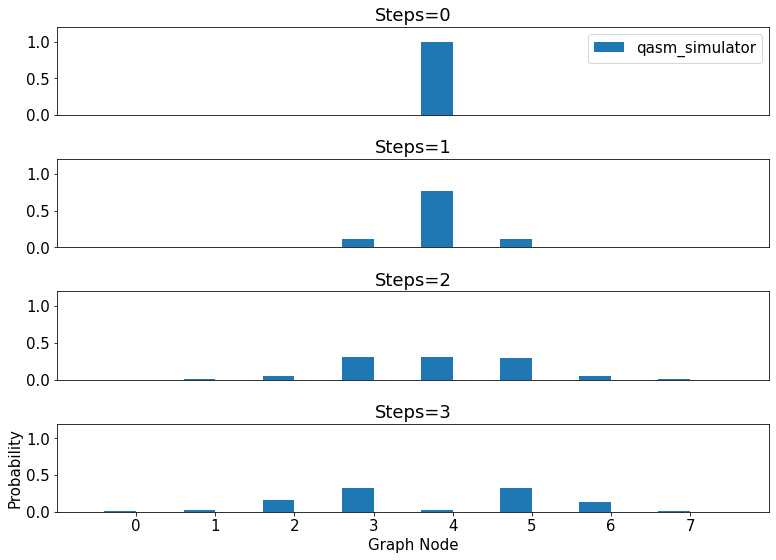

In [181]:
N = 8 
NCirc = 3
gamma =  1/(2*np.sqrt(2))
tList = [0,1,2,3]
time = [1]
c = [0,1] + [0 for x in range(N-3)] + [1]
initString = '100'
qft = dft(N, scale = 'sqrtn')
iqft = inv(qft)
adj = circulant_adjacency(N,c)
A = iqft@circulant_adjacency(N,c)@qft
diagA = np.diag(A)
U0 = unitary_ctqw(gamma, N, A, [],t)
diagU0 = np.diag(U0).tolist()
U = iqft@U0@qft

shots = 3000
diagUniOpList = multDiagUniOp(N,NCirc,gamma,A,tList)
multipleCircs = multContCirc(NCirc,diagUniOpList,tList,initString)
plotMultipleQiskit(NCirc,multipleCircs,tList,shots)
multResultSimN3 = multResultsSim(multipleCircs,shots)
print(multResultSimN3)

### IBM Results

In [149]:
IBMQ.save_account('97d2733b7c11b188b0581ae8a2beda54ce1c210ae0274df456ec1ddbe7df9fddf6d104015c59d4f7ce651304bf82fbd8e7178ea759d5f6f8058950d9e7ebf2ad')
IBMQ.load_account()
def getJob(jobID,provider,backend):
    job = backend.retrieve_job(jobID)
    resultCount = job.result().get_counts()
    return resultCount

def setProvider(hub,group,project):
    provider = IBMQ.get_provider(hub=hub, group=group, project=project)
    return provider

def leastBusy(minQubits,provider):
    large_enough_devices = provider.backends(filters=lambda x: x.configuration().n_qubits > minQubits  and not x.configuration().simulator)
    leastBusybackend = least_busy(large_enough_devices)
    return leastBusybackend

def listBackends(provider):
    for backend in provider.backends():
        print( backend.name())

def getJob(jobID,provider,backend):
    job = backend.retrieve_job(jobID)
    resultCount = job.result().get_counts()
    return resultCount

def run(circuit, backend, **kwargs):
    if type(backend) is str:
        backend = Aer.get_backend(backend)
    return execute(circuit, backend, **kwargs)

def printBestSeed(qc,basisGatesD,deviceBackend,startSeed,endSeed):
    dict = {}
    dict2 = {}
    for i in range(startSeed,endSeed):
        qCirc = transpile(qc,basis_gates=basisGatesD,backend=deviceBackend,optimization_level=3,layout_method='noise_adaptive',seed_transpiler=i)
        dict[i] = qCirc.count_ops()['cx']
        dict2[i] = qCirc.depth()
    print(min(dict.items(), key=lambda x: x[1])) 
    print(min(dict2.items(), key=lambda x: x[1]))

configrc.store_credentials:WARNING:2021-07-08 23:34:17,754: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2021-07-08 23:34:18,299: Credentials are already in use. The existing account in the session will be replaced.


In [150]:
provider = setProvider('ibm-q-minho','academicprojects','quantalab')
##leastBusyBackend =leastBusy(10,provider)
##print("Least busy backend:",leastBusyBackend)
##32QV
bogBackend = provider.get_backend('ibmq_bogota')
# parisBackend = provider.get_backend('ibmq_paris')
manhatBackend = provider.get_backend('ibmq_manhattan')
torontoBackend = provider.get_backend('ibmq_toronto')
mumbaiBackend = provider.get_backend('ibmq_mumbai')
casablancaBackend = provider.get_backend('ibmq_casablanca')
yorkTown = provider.get_backend('ibmq_5_yorktown')
manila = provider.get_backend('ibmq_manila')
santiago = provider.get_backend('ibmq_santiago')
montreal = provider.get_backend('ibmq_montreal')


##Chosen
backend = santiago
backend2 = manila
backend3 = torontoBackend
backend4 = mumbaiBackend
backend5 = montreal
mumbaiGates = ['cx', 'id', 'rz', 'sx', 'x']
torontoGates = ['cx', 'id', 'rz', 'sx', 'x']

#simulator = provider.get_backend('ibmq_qasm_simulator')
#method = 'noise_adaptive'
method = 'noise_adaptive'
#basisGatesD=['cx','rz','h','u3']
#printBestSeed(groverCircN3M0,basisGatesD,backend,0,100)

In [151]:
def runContForIBM(N,diagUniOp,initString,t,backend,method,gates):
    qreg = QuantumRegister(N)
    creg = ClassicalRegister(N)
    circ = QuantumCircuit(qreg,creg)
    if t == 0: 
        circ = initialCond(circ,initString,N)
        circ.measure(qreg,creg)
        circ = transpile(circ,backend,basis_gates = gates,layout_method=method,optimization_level=3)
        return circ 
    else:
        circ = initialCond(circ,initString,N)
        circ.append(QFT(N,do_swaps=False,approximation_degree=0,inverse=True,name='    QFT    '),range(N))
        circ.append(diagUniOp,range(N))
        circ.append(QFT(N,do_swaps=False,approximation_degree=0,inverse=False,name='    IQFT    '),range(N))
        circ.measure(qreg,creg)
    circ = transpile(circ,backend,basis_gates = gates,layout_method=method,optimization_level=3)
    return circ

def executeCont(backend,method,gates,N,diagUniOpList,initString,timeList,shots):
    retrievedJobList = []
    for t,diagUniOp in zip(timeList,diagUniOpList):
        circ = runContForIBM(N,diagUniOp,initString,t,backend,method,gates)
        job = execute([circ]*10,backend,shots=shots)
        retrievedJob = backend.retrieve_job(job.job_id())
        retrievedJobList.append(retrievedJob)
    return retrievedJobList

def getJobIds(jobList):
    jobIdList = []
    for job in jobList:
        jobIdList.append(job.job_id())
    return jobIdList

def retrieveJobsFromId(jobIdList,backend):
    retrievedJobList = []
    for jobId in jobIdList:
        retrievedJob = backend.retrieve_job(jobId)
        retrievedJobList.append(retrievedJob)
    return retrievedJobList

def getJobResults(jobList):
    multipleCountList = []
    for job in jobList:
        multipleCountList.append(job.result().get_counts())
    return multipleCountList

def multDictResults(resultList):
    multResultList = []
    avgValue = 0
    for result in resultList:
        newResult = []
        for counts in result:
            correctedResult = { int(k[::-1],2) : v/shots for k, v in counts.items()}
            newResult.append(correctedResult)
        multResultList.append(newResult)
    return multResultList

In [163]:
N = 8 
NCirc = 3
gamma =  1/(2*np.sqrt(2))
tList = [2]
c = [0,1] + [0 for x in range(N-3)] + [1]
initString = '100'
qft = dft(N, scale = 'sqrtn')
iqft = inv(qft)
adj = circulant_adjacency(N,c)
A = iqft@circulant_adjacency(N,c)@qft
diagA = np.diag(A)
U0 = unitary_ctqw(gamma, N, A, [],t)
diagU0 = np.diag(U0).tolist()
U = iqft@U0@qft
# method = 'noise_adaptive'
method = 'trivial'

shots = 3000
diagUniOpList = multDiagUniOp(N,NCirc,gamma,A,tList)
#jobList = executeCont(backend3,method,torontoGates,NCirc,diagUniOpList,initString,tList,shots)


In [182]:
jobIds = getJobIds(jobList)
print(jobIds)

['60e77e1e42e4710e28273048']


In [183]:
torontoConTIdList = ['60e73bfab5880803c06cba54', '60e73bfd5d743268477a6872', '60e77e1e42e4710e28273048', '60e73c03b588082eef6cba56']
retrievedJobs = retrieveJobsFromId(torontoConTIdList,backend3)

In [184]:
resultList = getJobResults(retrievedJobs)

In [185]:
correctedResults = multDictResults(resultList)
# print(correctedResults)

In [186]:
def fidDictList(results,multResultsSim):
    resultListFid = []
    resultListListFid = []
    for results,resultsSim in zip(correctedResults,multResultsSim):
        for resultDict in results:
            #print("IBM %s"%resultDict)
            #print("Sim %s"%resultsSim)
            hFid = (1-(hellinger_distance(resultsSim,resultDict))**2)
            #print("Hellinger fid %s"%(1-(hellinger_distance(resultsSim,resultDict))**2))
            resultListFid.append((resultDict,hFid))
        resultListListFid.append(resultListFid)
        resultListFid = []
    return resultListListFid

def maxFidIbmResultDict(results,multResultsSim):
    resultListFid = fidDictList(results,multResultsSim)
    maxFidDictList = []
    for a in resultListFid:
        maxFidDict = max(a,key=lambda x:x[1])
        print(maxFidDict)
        print()
        maxFidDictList.append(maxFidDict[0])
    return maxFidDictList

maxFidDict = maxFidIbmResultDict(correctedResults,multResultSimN3)
print(maxFidDict)
#print()
print(multResultSimN3)

({0: 0.039, 4: 0.9306666666666666, 2: 0.0016666666666666668, 6: 0.015333333333333332, 1: 0.0003333333333333333, 5: 0.013}, 0.9647106647418524)

({0: 0.07133333333333333, 4: 0.5163333333333333, 2: 0.04566666666666667, 6: 0.03266666666666666, 1: 0.043, 5: 0.15966666666666668, 3: 0.11466666666666667, 7: 0.016666666666666666}, 0.9013185422111691)

({0: 0.053, 4: 0.2623333333333333, 2: 0.129, 6: 0.06966666666666667, 1: 0.05266666666666667, 5: 0.20566666666666666, 3: 0.17766666666666667, 7: 0.05}, 0.9214351433311447)

({0: 0.035333333333333335, 4: 0.041, 2: 0.165, 6: 0.079, 1: 0.09233333333333334, 5: 0.25233333333333335, 3: 0.27166666666666667, 7: 0.06333333333333334}, 0.9691290362668966)

[{0: 0.039, 4: 0.9306666666666666, 2: 0.0016666666666666668, 6: 0.015333333333333332, 1: 0.0003333333333333333, 5: 0.013}, {0: 0.07133333333333333, 4: 0.5163333333333333, 2: 0.04566666666666667, 6: 0.03266666666666666, 1: 0.043, 5: 0.15966666666666668, 3: 0.11466666666666667, 7: 0.016666666666666666}, {0: 

[{0: 0.039, 4: 0.9306666666666666, 2: 0.0016666666666666668, 6: 0.015333333333333332, 1: 0.0003333333333333333, 5: 0.013}, {0: 0.07133333333333333, 4: 0.5163333333333333, 2: 0.04566666666666667, 6: 0.03266666666666666, 1: 0.043, 5: 0.15966666666666668, 3: 0.11466666666666667, 7: 0.016666666666666666}, {0: 0.053, 4: 0.2623333333333333, 2: 0.129, 6: 0.06966666666666667, 1: 0.05266666666666667, 5: 0.20566666666666666, 3: 0.17766666666666667, 7: 0.05}, {0: 0.035333333333333335, 4: 0.041, 2: 0.165, 6: 0.079, 1: 0.09233333333333334, 5: 0.25233333333333335, 3: 0.27166666666666667, 7: 0.06333333333333334}]
[{4: 1.0}, {4: 0.7686666666666667, 3: 0.11133333333333334, 5: 0.114, 2: 0.0033333333333333335, 6: 0.0023333333333333335, 7: 0.0003333333333333333}, {3: 0.31633333333333336, 4: 0.30633333333333335, 2: 0.041, 5: 0.2816666666666667, 7: 0.0026666666666666666, 6: 0.048, 1: 0.0036666666666666666, 0: 0.0003333333333333333}, {5: 0.324, 2: 0.144, 6: 0.13833333333333334, 3: 0.31666666666666665, 1: 0.0

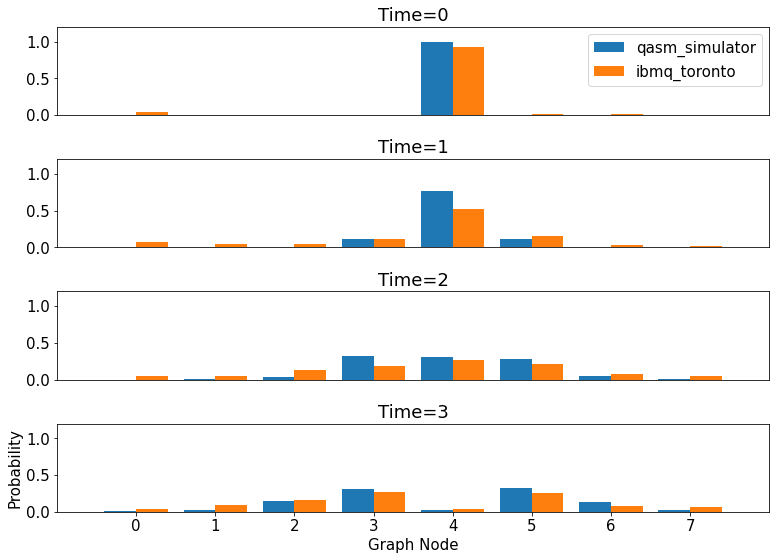

In [214]:
print(maxFidDict)
print(multResultSimN3)
plotMultipleQiskitIbmSim(NCirc,maxFidDict,multResultSimN3,tList,shots,True,backend3)